In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np

import h5py

from astropy.cosmology import Planck18

import scipy.interpolate as sip
from scipy.integrate import cumtrapz
import scipy.stats as ss

import jax.numpy as jnp

import numpyro
import numpyro.distributions as dist

We want to infer is the DM - redshift relation for FRBs.

The parameters are: 

* Milky way DM -- fix to be 100 pc/ cm^3 (It varies based on galactic latitude, but smaller than scatter in other contributions. It is also not perfectly known, but uncertainty is small compared to other uncertainties.)

* Cosmological/ IGM DM
    * $\Omega_m$ -- fix to Planck value
    * $\Omega_\Lambda$ -- fix to Planck value, 1 - $\Omega_m$
    * $K$, a prefactor that depends on $H_0$, $\Omega_b$ and some other stuff
    * $F$, a paramter that controls the scatter in this relation and depends on the strength of feedback on redistributing baryons

* Host galaxy DM: drawn from a lognormal distribution
    * $\mu$, mean of underlying Normal distribution
    * $\sigma$, standard deviation of underlying Normal distribution 

In [2]:
Om = Planck18.Om(0)
zmax = 1
DM_MW = 100


def mean_DM_IGM_integrand(z):
    zp1 = 1.0 + z
    return zp1 / (Om*zp1**3 + (1 - Om))**0.5

zs_interp = np.linspace(0, zmax, 1000)  
DM_IGM_interp = cumtrapz(mean_DM_IGM_integrand(zs_interp), zs_interp, initial = 0)
mean_DM_IGM_sip = sip.interp1d(zs_interp, DM_IGM_interp)

def mean_DM_IGM(z, K):
    return K * mean_DM_IGM_sip(z)

def mean_DM_IGM_jax(z, K):
    return K * jnp.interp(z, zs_interp, DM_IGM_interp)

def lognormal_prob(x, m, s2):
    return (2 * np.pi*s2)**-0.5 * np.exp(-0.5 * (np.log(x) - m)**2/s2)/x

def pDM_IGM_givenz(DM, z, K, F): #assume this is lognormal, although this is really a more complicated distribution, see Eq. 4 of Macquart+ 2020 https://arxiv.org/pdf/2005.13161.pdf
    sig2 = F**2 * z**-1
    mu = np.log(mean_DM_IGM(z, K))
    return lognormal_prob(DM, mu, sig2)

def pDM_host_givenz(DM, z, mu, sigma): #include a redshifting term 
    return lognormal_prob(DM, np.log(mu) - np.log(1.0 + z), sigma**2)

def pDM_IGM_givenz_host_MW(DM, z, K, F, DM_host, DM_MW):
    return pDM_IGM_givenz(DM - DM_host - DM_MW, z, K, F)

def draw_DM_IGM_givenz(z, K, F, ndraw):
    logDM = np.log(mean_DM_IGM(z, K)) + F * z**-0.5 * np.random.randn(ndraw)
    return np.exp(logDM)

def draw_DM_host_givenz(z, mu, sigma, ndraw): #include a redshifting term
    logDM = np.log(mu) + sigma*np.random.randn(ndraw)
    return np.exp(logDM)/ (1.0 + z)

def draw_total_DM(z, K, F, mu, sigma, ndraw):
    DM_IGM = draw_DM_IGM_givenz(z, K, F, ndraw)
    DM_host = draw_DM_host_givenz(z, mu, sigma, ndraw)
    return DM_IGM + DM_host + DM_MW


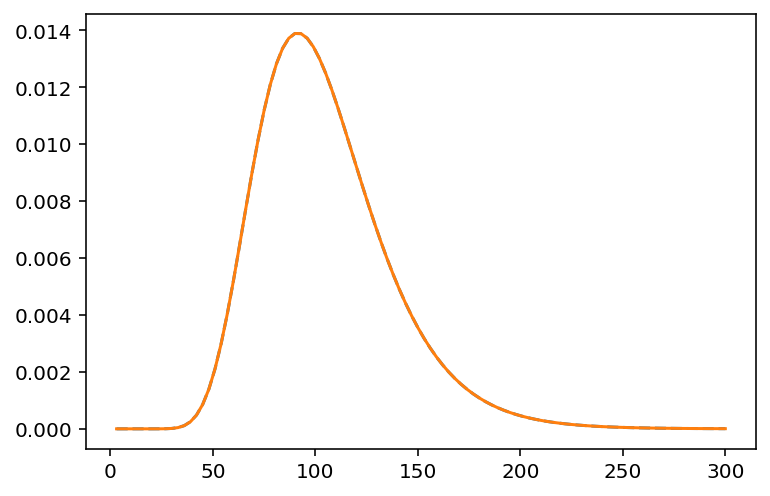

In [3]:
plt.plot(np.linspace(3,300,100), lognormal_prob(np.linspace(3,300,100), np.log(100), 0.3**2), ls = '--')
plt.plot(np.linspace(3,300,100), np.exp(dist.LogNormal(loc = np.log(100), scale = 0.3).log_prob(np.linspace(3,300,100))))

313.7117299826282 246.3374859083475


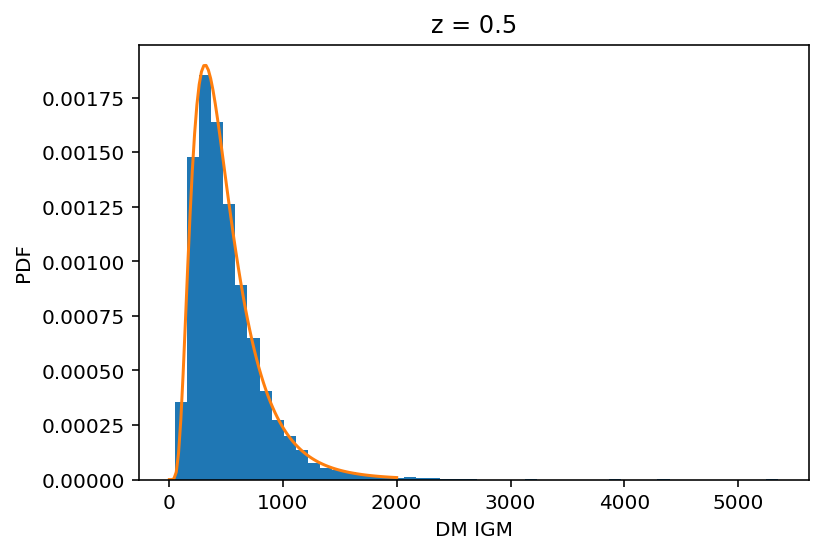

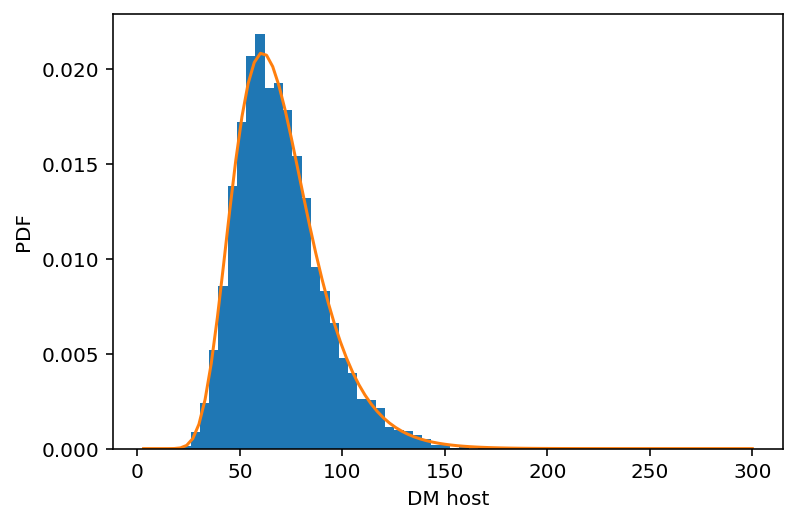

In [4]:
DM_IGM = draw_DM_IGM_givenz(z = 0.5, K = 800, F = 0.4, ndraw = 10000)
DM_host = draw_DM_host_givenz(z = 0.5, mu = 100, sigma = 0.3, ndraw = 10000)

plt.hist(DM_IGM, bins = 50, density = True)
plt.plot(np.linspace(3, 2000, 100), pDM_IGM_givenz(np.linspace(3, 2000, 100), 0.5, 800, 0.4))
plt.xlabel('DM IGM')
plt.ylabel('PDF')
plt.title('z = 0.5')

print(np.std(DM_IGM), 0.4 * 0.5**-0.5 * mean_DM_IGM(0.5, 800))
plt.show()

plt.hist(DM_host, bins = 50, density = True)
plt.plot(np.linspace(3, 300, 100), pDM_host_givenz(np.linspace(3, 300, 100), 0.5, 100, 0.3))
plt.xlabel('DM host')
plt.ylabel('PDF')
plt.show()


Text(0, 0.5, 'mean DM IGM')

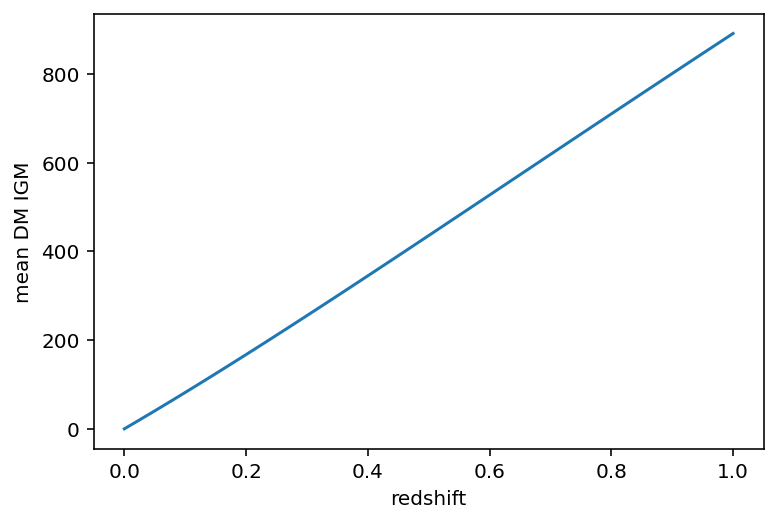

In [5]:
plt.plot(np.linspace(0, 1, 100), mean_DM_IGM(np.linspace(0, 1, 100), K = 800))
plt.xlabel('redshift')
plt.ylabel('mean DM IGM')

In [8]:
def compute_zscore_wrapped(x, mu, sigma, wrap):
    z = np.minimum(np.abs(x - mu), np.abs(x - mu - wrap))
    z = np.minimum(z, np.abs(x - mu + wrap))
    return z/sigma


def generate_mock_FRB_galaxies(K, F, mu, sigma, nFRBs):
    
    #draw galaxies; as a very toy model assume galaxies are uniformly distributed in 0 < z < 1
    #RA, Dec in radians
    ngals = nFRBs * 100
    zs = np.random.rand(ngals)
    RAs = 2 * np.pi * np.random.rand(ngals) #uniform between 0 and 2 * pi
    cosDs = -1 + 2*np.random.rand(ngals) #uniform between -1 and 1
    
    
    #pick random galaxies to be FRB hosts (with equal weights)
    gal_idx = np.random.choice(ngals, size = nFRBs, replace = False)
    
    #draw observed FRB properties DM, RA, Dec
    #assume (wrapped) Gaussian uncertainty on RA, cosDec
    
    sky_uncert = 0.2
    
    DM_FRB = np.zeros(nFRBs)
    RA_obs_FRB = np.zeros(nFRBs)
    Dec_obs_FRB = np.zeros(nFRBs)
    gal_weights = np.zeros((ngals, nFRBs))
    
    for i, gal in enumerate(gal_idx):
        DM_total = draw_total_DM(zs[gal], K, F, mu, sigma, ndraw=1)
        #assume no measurement uncertainty on DM
        DM_FRB[i] = DM_total
        
        RA_obs_FRB[i] = (RAs[gal] + sky_uncert * np.random.randn()) % (2 * np.pi) #between 0 and 2 * pi
        Dec_obs_FRB[i] = (np.arccos(cosDs[gal]) + sky_uncert * np.random.randn()) % np.pi #between 0 and pi
    
        #assign galaxy weights based on skymap probability, but need to make this a wrapped distribution
        RA_zscore = compute_zscore_wrapped(RAs, RA_obs_FRB[i], sky_uncert, 2 * np.pi)
        Dec_zscore = compute_zscore_wrapped(np.arccos(cosDs), Dec_obs_FRB[i], sky_uncert, np.pi)
        
        gal_weights[:, i] = ss.norm.pdf(RA_zscore) * ss.norm.pdf(Dec_zscore)
        
    return zs, RAs, cosDs, gal_idx, DM_FRB, RA_obs_FRB, Dec_obs_FRB, gal_weights


In [9]:
nFRBs = 100

In [10]:
zs, RAs, cosDs, gal_idx, DM_FRB, RA_obs_FRB, Dec_obs_FRB, gal_weights = generate_mock_FRB_galaxies(800, 0.4, 100, 0.3, nFRBs)

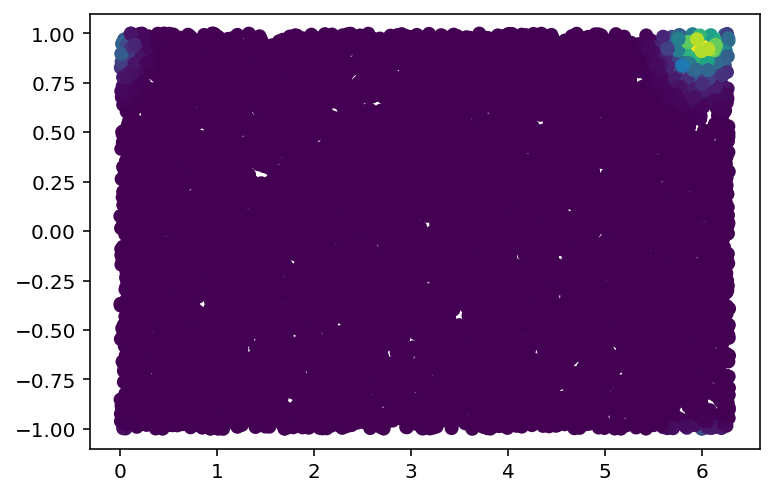

In [12]:
i = 30
plt.scatter(RAs, cosDs, c = gal_weights[:,i])
plt.scatter(RAs[gal_idx][i], cosDs[gal_idx][i])

In [15]:
z_gals_cut = np.zeros((100,nFRBs))
gal_weights_cut = np.zeros((100,nFRBs))
for i, idx in enumerate(gal_idx):
    sorted_gal_idx = np.argsort(gal_weights[:,i])[::-1] #sort galaxies from highest to lowest weight
    z_gals_cut[:,i] = zs[sorted_gal_idx][0:100] #only keep 100 most probable galaxies
    gal_weights_cut[:, i] = gal_weights[:,i][sorted_gal_idx][0:100]

In [16]:
gal_weights_cut.shape, z_gals_cut.shape, gal_weights.shape

((100, 100), (100, 100), (10000, 100))

In [17]:
gal_weights_cut = gal_weights_cut.T
z_gals_cut = z_gals_cut.T

In [18]:
def numpyro_model(z_gals_cut, gal_weights_cut, DM_FRB, DM_MW = 100):
    
    ####priors####
    
    #host DM contribution parameters
    mu = numpyro.sample("mu", dist.Uniform(20,200))
    sigma = numpyro.sample("sigma", dist.Uniform(0.1,0.5))
    
    #IGM DM contribution parameters
    K = numpyro.sample("K", dist.Uniform(500,1000))
    F = numpyro.sample("F", dist.Uniform(0.1, 0.6))
    
    DM_host_restframe = numpyro.sample('DM_host_restframe', dist.LogNormal(loc = jnp.log(mu), scale = sigma))
    
    #with numpyro.plate("data", len(DM_FRB)) as ind_FRB:
    #    galindex = numpyro.sample('galindex', dist.Categorical(probs = gal_weights_cut[ind_FRB]))
    #    z = numpyro.deterministic('z', jnp.take(z_gals_cut[ind_FRB], galindex))
    #    DM_IGM = numpyro.sample('DM_IGM', dist.LogNormal(loc = jnp.log(mean_DM_IGM_jax(z, K)), scale = F/jnp.sqrt(z)), obs = DM_FRB[ind_FRB] - DM_host_restframe/(1 + z) - DM_MW)
        
    with numpyro.plate("data", len(DM_FRB)):
        galindex = numpyro.sample('galindex', dist.Categorical(probs = gal_weights_cut))
        z = numpyro.deterministic('z', jnp.take(z_gals_cut, galindex))
        DM_IGM = numpyro.sample('DM_IGM', dist.LogNormal(loc = jnp.log(mean_DM_IGM_jax(z, K)), scale = F/jnp.sqrt(z)), obs = DM_FRB - DM_host_restframe/(1 + z) - DM_MW)
    

In [27]:
from numpyro import infer
import jax
sampler = infer.MCMC(infer.NUTS(numpyro_model), num_warmup = 2000, num_samples = 2000, num_chains = 4, progress_bar = True)
%time sampler.run(jax.random.PRNGKey(0), z_gals_cut, gal_weights_cut, DM_FRB, DM_MW = 100)

/var/folders/s1/r51mmkl15w73kqk4mq2jqq5r0000gn/T/ipykernel_25632/1185585335.py:3: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler = infer.MCMC(infer.NUTS(numpyro_model), num_warmup = 2000, num_samples = 2000, num_chains = 4, progress_bar = True)
<timed eval>:1: FutureWarning: Some algorithms will automatically enumerate the discrete latent site galindex of your model. In the future, enumerated sites need to be marked with `infer={'enumerate': 'parallel'}`.
sample: 100%|████████████████████████████████████████| 4000/4000 [00:12<00:00, 326.41it/s, 42 steps of size 5.21e-02. acc. prob=0.90]
<timed eval>:1: FutureWarning: Some algorithms will automatically enumerate the discrete latent site ga

CPU times: user 37.7 s, sys: 237 ms, total: 37.9 s
Wall time: 37.9 s


In [28]:
samples = sampler.get_samples()

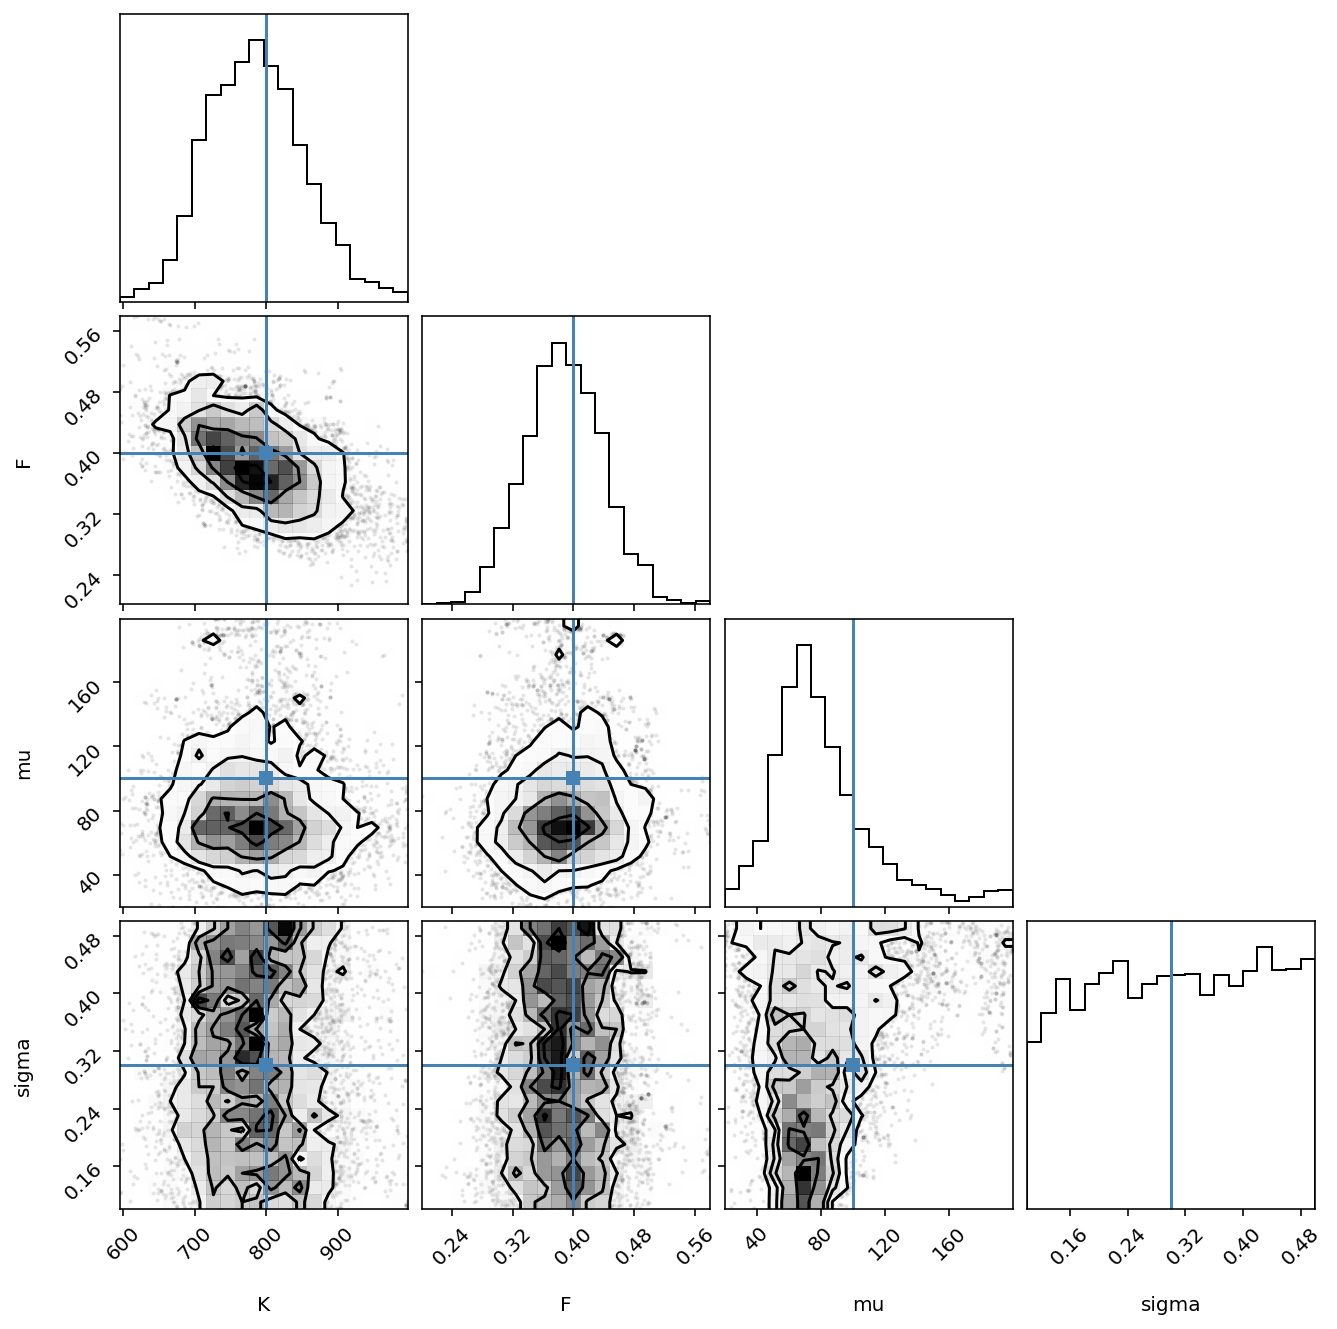

In [29]:
import corner
corner.corner(np.column_stack([samples[n] for n in ['K', 'F', 'mu', 'sigma']]), labels = ['K', 'F', 'mu', 'sigma'], truths = [800, 0.4, 100, 0.3]);

probability model:

Draw mu, sigma, K, F from prior distributions.

For each mu, sigma, draw DM_host_restframe. This is the same for all host galaxies, and follows a lognormal distribution with mean log(mu), scale sigma. For each potential host galaxy, DM_host is then DM_host_restframe/ (1 + z_gal). 

```
mu ~ prior
sigma ~ prior
K ~ prior
F ~ prior

DM_host_restframe = numpyro.sample('DM_host_restframe', dist.LogNormal(loc = jnp.log(mu), scale = sigma))
```

Given DM_host_redshifted, we know that (DM_IGM = DM_FRB - DM_host_restframe/ ( 1 + z_gal) - DM_MW) follows a lognormal distribution with mean and standard deviation that depend on K, F and z_gal. Increment model log likelihood by this sum of z_gal. Depends on DM_host_restframe, DM_MW, K, F, and list of possible z_gal.
For each FRB with (perfectly) measured DM_FRB,
```
numpyro.factor('DM_cosmic', jnp.logsumexp(DM_IGM_logprob(DM_IGM = DM_FRB - DM_host_restframe/(1 + z_gals) - DM_MW, z = z_gals, K = K, F = F))) #evaluate over array of z_gals
```


Selection effects: Assume we include all FRBs out to some maximum DM, and we include completeness correction in galaxy catalog, so we don't have to worry about the edge of the galaxy catalog.
To evaluate P_det(mu, sigma, K, F), for a fixed mu, sigma, K, F, we can draw p(z) from a uniform-in-comoving volume prior (approximating host galaxy redshift distribution on large scales), draw DMs for them for a fiducial choice of mu, sigma, K, F, and calculate fraction that is less than DM_max. 
The DMs drawn in this way that satisfy DM < DM_max is our "found injection set," as well as the z's that they were drawn from. Keep track of the probability of DM drawn from this z for these fiducial paramters.
Then we can use same DM_host_restframe sample that is drawn at every mu, sigma, and evaluate p(DM_i | DM_host_restframe, K, F, z_i) for each DM_i, z_i sample in the found injection set. Then we can reweight (to think more about later!).
